# 01_data_build_colored
- Author: 정재훈
- Date: 2025-11-10
- Goal: Colored MNIST 생성(색/배경 옵션)
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [7]:
# ==========================================
# Colored MNIST Preprocessing + EDA Pipeline
# - Original gray MNIST (60k)
# - Deskew augmentation (10k)
# - Font augmentation with MaruBuri (10k)
# - Colored MNIST generation (80k)
# - 8:1:1 train/val/test split
# - Basic EDA at each major step
# ==========================================

# ================================
# Cell 1. Imports & global config
# ================================
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import ndimage
from PIL import Image, ImageDraw, ImageFont

from sklearn.model_selection import train_test_split

# For notebook
%matplotlib inline

# Global random seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Matplotlib basic style (English only)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

print("[INFO] Libraries imported.")



[INFO] Libraries imported.


In [8]:
# ======================================
# Cell 2. Paths & augmentation settings
# ======================================
# Assume this notebook is located at the project root
BASE_DIR = os.getcwd()

# Raw data dirs
RAW_DATA_DIR = os.path.join(BASE_DIR, "data", "raw")
RAW_MNIST_DIR = os.path.join(RAW_DATA_DIR, "mnist")
RAW_FONTS_DIR = os.path.join(RAW_DATA_DIR, "fonts")

# MNIST train npz path
MNIST_TRAIN_PATH = os.path.join(RAW_MNIST_DIR, "mnist_train.npz")

# Processed output dir
PROC_DIR = os.path.join(BASE_DIR, "data", "processed", "colored_mnist")
os.makedirs(PROC_DIR, exist_ok=True)

# Final output npz path
SAVE_PATH = os.path.join(PROC_DIR, "colored_mnist_80k_splits_8_1_1.npz")

# Augmentation sizes: 60k + 10k + 10k = 80k
DESKEW_AUG_TARGET = 10_000
FONT_AUG_TARGET = 10_000
TARGET_TOTAL_SAMPLES = 80_000

print("[INFO] BASE_DIR        :", BASE_DIR)
print("[INFO] MNIST_TRAIN_PATH:", MNIST_TRAIN_PATH)
print("[INFO] RAW_FONTS_DIR   :", RAW_FONTS_DIR)
print("[INFO] PROC_DIR        :", PROC_DIR)
print("[INFO] DESKEW_AUG_TARGET:", DESKEW_AUG_TARGET)
print("[INFO] FONT_AUG_TARGET  :", FONT_AUG_TARGET)

[INFO] BASE_DIR        : /Users/jaehun_jung/colored-mnist-classification/notebooks
[INFO] MNIST_TRAIN_PATH: /Users/jaehun_jung/colored-mnist-classification/notebooks/data/raw/mnist/mnist_train.npz
[INFO] RAW_FONTS_DIR   : /Users/jaehun_jung/colored-mnist-classification/notebooks/data/raw/fonts
[INFO] PROC_DIR        : /Users/jaehun_jung/colored-mnist-classification/notebooks/data/processed/colored_mnist
[INFO] DESKEW_AUG_TARGET: 10000
[INFO] FONT_AUG_TARGET  : 10000


In [9]:
# ===========================================
# Cell 3. Load MNIST (uint8, no normalization)
# ===========================================
def load_mnist_train_npz_uint8(train_path: str):
    """
    Load MNIST train npz as uint8 images (no normalization).
    Expected keys: 'train_images' (N, 28, 28), 'train_labels' (N,)
    
    Returns
    -------
    X_gray_uint8 : np.ndarray, shape (N, 28, 28), dtype uint8
        Grayscale pixel values in [0, 255]
    y_digit : np.ndarray, shape (N,), dtype int64
        Digit labels in [0, 9]
    """
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"[ERROR] mnist_train.npz not found at: {train_path}")
    
    data = np.load(train_path)
    
    print("[DEBUG] npz keys:", data.files)
    
    if "train_images" not in data or "train_labels" not in data:
        raise KeyError("[ERROR] npz must contain 'train_images' and 'train_labels'")
    
    X_gray_uint8 = data["train_images"].astype(np.uint8)  # (N, 28, 28)
    y_digit = data["train_labels"].astype(np.int64)       # (N,)
    
    return X_gray_uint8, y_digit


X_gray_all_u8, y_digit_all = load_mnist_train_npz_uint8(MNIST_TRAIN_PATH)

print("\n[INFO] Loaded MNIST train (uint8):")
print("  X_gray_all_u8 shape:", X_gray_all_u8.shape)  # expected: (60000, 28, 28)
print("  y_digit_all    shape:", y_digit_all.shape)
print("  dtype / min / max:", X_gray_all_u8.dtype, X_gray_all_u8.min(), X_gray_all_u8.max())

# Sanity checks
assert X_gray_all_u8.shape[0] == 60000, "[ERROR] Train size is not 60000!"
assert X_gray_all_u8.shape[1:] == (28, 28), "[ERROR] Each image must be 28x28!"
assert y_digit_all.shape[0] == 60000, "[ERROR] Label length mismatch!"

[DEBUG] npz keys: ['train_images', 'train_labels']

[INFO] Loaded MNIST train (uint8):
  X_gray_all_u8 shape: (60000, 28, 28)
  y_digit_all    shape: (60000,)
  dtype / min / max: uint8 0 255



[EDA] Label distribution on original MNIST
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


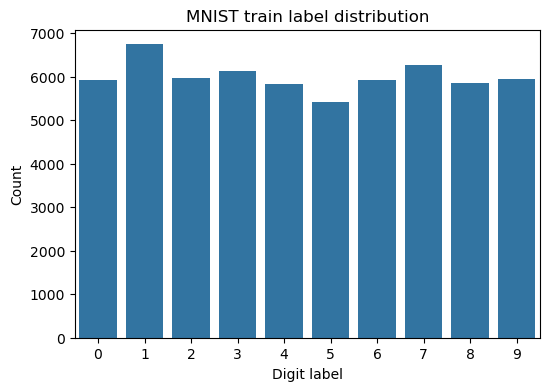


[EDA] Pixel intensity statistics (subsample 5k images)
  mean: 33.206704336734695
  std : 78.4227851241812


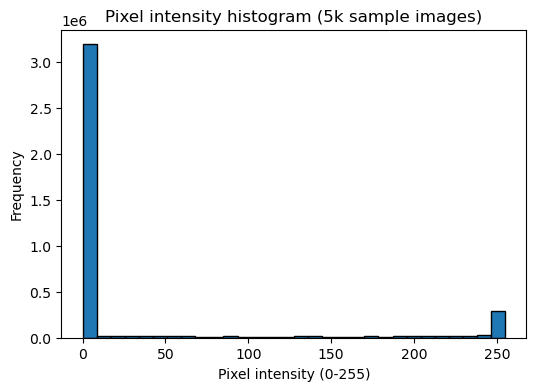

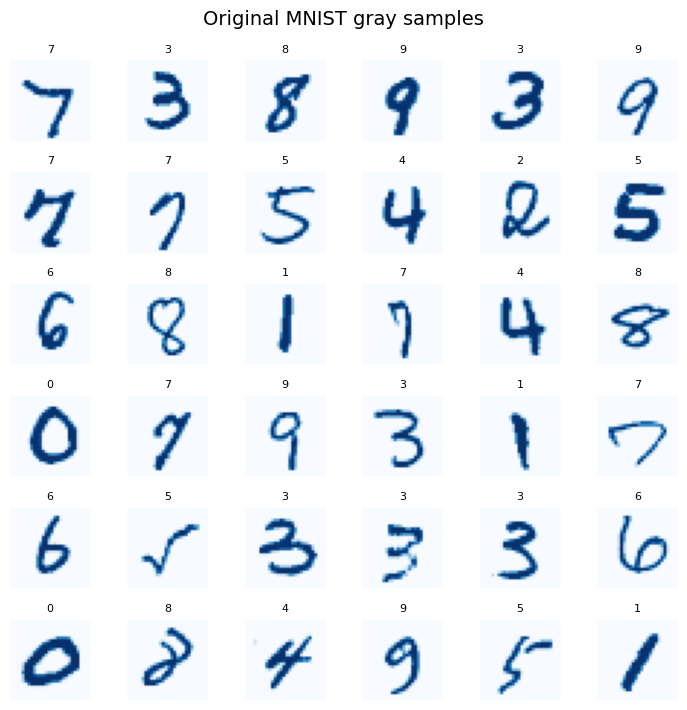

In [10]:
# =======================================
# Cell 4. Basic EDA on original gray MNIST
# =======================================
def plot_digits_gray(data, labels, row_size=6, n_samples=36, cmap=plt.cm.Blues):
    """
    Visualize sample gray-scale digits.
    
    Parameters
    ----------
    data : np.ndarray, shape (N, 28, 28) or (N, 784)
    labels : np.ndarray, shape (N,)
    row_size : int, number of rows in the grid
    n_samples : int, number of images to visualize
    """
    assert data.shape[0] == labels.shape[0]
    
    n = min(n_samples, data.shape[0])
    idxs = np.random.choice(data.shape[0], size=n, replace=False)
    
    plt.figure(figsize=(row_size * 1.2, row_size * 1.2))
    for i, idx in enumerate(idxs):
        if data[idx].ndim == 1:
            img = data[idx].reshape(28, 28)
        else:
            img = data[idx]
        
        ax = plt.subplot(row_size, row_size, i + 1)
        ax.imshow(img, cmap=cmap)
        ax.axis("off")
        ax.set_title(int(labels[idx]), fontsize=8)
    plt.suptitle("Original MNIST gray samples", fontsize=14)
    plt.tight_layout()
    plt.show()


print("\n[EDA] Label distribution on original MNIST")
label_counts = pd.Series(y_digit_all).value_counts().sort_index()
print(label_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Digit label")
plt.ylabel("Count")
plt.title("MNIST train label distribution")
plt.show()

print("\n[EDA] Pixel intensity statistics (subsample 5k images)")
sample_flat = X_gray_all_u8[:5000].reshape(-1)
print("  mean:", float(sample_flat.mean()))
print("  std :", float(sample_flat.std()))

plt.figure(figsize=(6, 4))
plt.hist(sample_flat, bins=30, edgecolor="black")
plt.xlabel("Pixel intensity (0-255)")
plt.ylabel("Frequency")
plt.title("Pixel intensity histogram (5k sample images)")
plt.show()

plot_digits_gray(X_gray_all_u8, y_digit_all, row_size=6, n_samples=36)


In [11]:
# ==========================================
# Cell 5. Deskew functions (single + batch)
# ==========================================
def compute_image_moments(img_f32: np.ndarray):
    """
    Compute second-order moments (covariance) and center of mass for an image.
    
    Parameters
    ----------
    img_f32 : np.ndarray, shape (H, W), float32
    
    Returns
    -------
    cov : np.ndarray, shape (2, 2)
        Covariance matrix of row/column coordinates weighted by pixel intensities.
    center : np.ndarray, shape (2,)
        Center of mass (row_center, col_center).
    """
    assert img_f32.ndim == 2
    h, w = img_f32.shape
    c0, c1 = np.mgrid[:h, :w]  # c0: rows, c1: cols

    total = img_f32.sum()
    if total == 0:
        center = np.array([h / 2.0, w / 2.0], dtype=np.float32)
        cov = np.eye(2, dtype=np.float32)
        return cov, center

    m0 = (c0 * img_f32).sum() / total  # mean row
    m1 = (c1 * img_f32).sum() / total  # mean col

    mu11 = ((c0 - m0) * (c1 - m1) * img_f32).sum() / total
    mu20 = (((c0 - m0) ** 2) * img_f32).sum() / total
    mu02 = (((c1 - m1) ** 2) * img_f32).sum() / total

    cov = np.array([[mu20, mu11],
                    [mu11, mu02]], dtype=np.float32)
    center = np.array([m0, m1], dtype=np.float32)
    return cov, center


def deskew_image(img_u8: np.ndarray, max_skew: float = 0.4) -> np.ndarray:
    """
    Deskew a single MNIST image using second-order moments.
    
    Parameters
    ----------
    img_u8 : np.ndarray, shape (28, 28), uint8
    max_skew : float
        Maximum allowed skew factor (alpha) in abs value.
    
    Returns
    -------
    deskewed_u8 : np.ndarray, shape (28, 28), uint8
    """
    assert img_u8.shape == (28, 28)

    img_f32 = img_u8.astype(np.float32)
    cov, center = compute_image_moments(img_f32)
    mu20, mu11 = cov[0, 0], cov[0, 1]

    if mu20 == 0:
        # Not enough variance: just return original
        return img_u8.copy()

    alpha = mu11 / mu20
    alpha = np.clip(alpha, -max_skew, max_skew)

    # Affine transform matrix (row/col space)
    # [r']   [1     0] [r] + [0]
    # [c'] = [alpha 1] [c] + [-alpha * center_row]
    affine = np.array([[1.0, 0.0],
                       [alpha, 1.0]], dtype=np.float32)
    offset = np.array([0.0, -alpha * center[0]], dtype=np.float32)

    deskewed_f32 = ndimage.affine_transform(
        img_f32,
        affine,
        offset=offset,
        order=1,
        mode="constant",
        cval=0.0
    )

    deskewed_u8 = np.clip(deskewed_f32, 0, 255).astype(np.uint8)
    return deskewed_u8


def apply_deskew_batch(X_gray_u8: np.ndarray, indices: np.ndarray) -> np.ndarray:
    """
    Apply deskew to a batch of images selected by indices.
    
    Parameters
    ----------
    X_gray_u8 : np.ndarray, shape (N, 28, 28), uint8
    indices : np.ndarray, shape (K,), int
    
    Returns
    -------
    out : np.ndarray, shape (K, 28, 28), uint8
    """
    K = indices.shape[0]
    H, W = X_gray_u8.shape[1], X_gray_u8.shape[2]
    out = np.empty((K, H, W), dtype=np.uint8)

    for i, idx in enumerate(indices):
        out[i] = deskew_image(X_gray_u8[idx])

        if (i + 1) % 2000 == 0:
            print(f"[deskew] processed {i + 1}/{K}")

    return out


[INFO] Original N: 60000
[INFO] deskew_indices     shape: (10000,)
[INFO] font_indices       shape: (10000,)
[INFO] overlap(deskew,font): 0
[deskew] processed 2000/10000
[deskew] processed 4000/10000
[deskew] processed 6000/10000
[deskew] processed 8000/10000
[deskew] processed 10000/10000
[INFO] X_deskew_u8: (10000, 28, 28) uint8
[INFO] y_deskew   : (10000,)


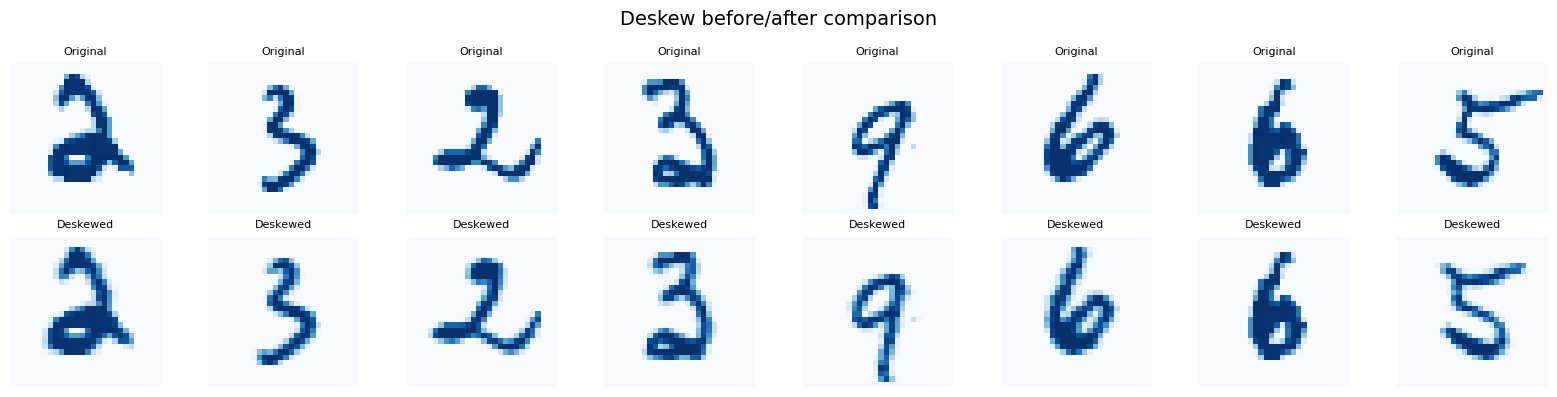

In [12]:
# ==========================================
# Cell 6. Select indices for deskew / font
# ==========================================
N_ORIG = X_gray_all_u8.shape[0]
print("\n[INFO] Original N:", N_ORIG)

rng_indices = np.random.default_rng(RANDOM_SEED)

# Make deskew and font indices disjoint
deskew_indices = rng_indices.choice(N_ORIG, size=DESKEW_AUG_TARGET, replace=False)
available_for_font = np.setdiff1d(np.arange(N_ORIG), deskew_indices)
font_indices = rng_indices.choice(available_for_font, size=FONT_AUG_TARGET, replace=False)

print("[INFO] deskew_indices     shape:", deskew_indices.shape)
print("[INFO] font_indices       shape:", font_indices.shape)
print("[INFO] overlap(deskew,font):",
      np.intersect1d(deskew_indices, font_indices).size)

# Generate deskewed images
X_deskew_u8 = apply_deskew_batch(X_gray_all_u8, deskew_indices)
y_deskew = y_digit_all[deskew_indices]

print("[INFO] X_deskew_u8:", X_deskew_u8.shape, X_deskew_u8.dtype)
print("[INFO] y_deskew   :", y_deskew.shape)


# (EDA) Visualize deskew before/after
def show_deskew_comparison(X_orig_u8, X_deskew_u8, indices, n=8):
    """
    Visual comparison between original and deskewed images.
    """
    n = min(n, len(indices))
    plt.figure(figsize=(n * 2, 4))
    
    for i in range(n):
        idx = indices[i]
        ax1 = plt.subplot(2, n, i + 1)
        ax1.imshow(X_orig_u8[idx], cmap=plt.cm.Blues)
        ax1.axis("off")
        ax1.set_title("Original", fontsize=8)

        ax2 = plt.subplot(2, n, i + 1 + n)
        ax2.imshow(X_deskew_u8[i], cmap=plt.cm.Blues)
        ax2.axis("off")
        ax2.set_title("Deskewed", fontsize=8)
    
    plt.suptitle("Deskew before/after comparison", fontsize=14)
    plt.tight_layout()
    plt.show()


show_deskew_comparison(X_gray_all_u8, X_deskew_u8, deskew_indices[:8], n=8)

[font] generated 2000/10000
[font] generated 4000/10000
[font] generated 6000/10000
[font] generated 8000/10000
[font] generated 10000/10000
[INFO] X_font_u8: (10000, 28, 28) uint8
[INFO] y_font   : (10000,)


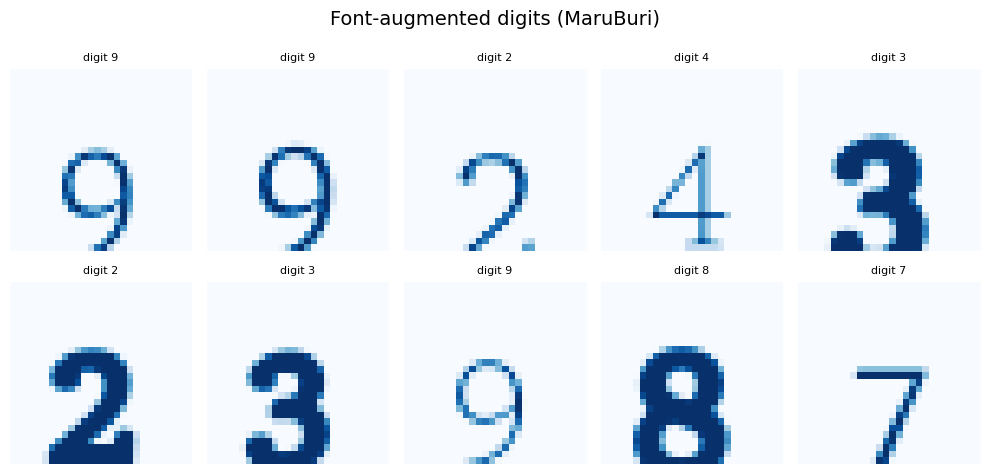

In [13]:
# ==========================================
# Cell 7. Font-based augmentation (MaruBuri)
# ==========================================
# Define MaruBuri font paths (make sure these files exist)
FONT_PATHS = [
    os.path.join(RAW_FONTS_DIR, "MaruBuri-ExtraLight.ttf"),
    os.path.join(RAW_FONTS_DIR, "MaruBuri-Light.ttf"),
    os.path.join(RAW_FONTS_DIR, "MaruBuri-Regular.ttf"),
    os.path.join(RAW_FONTS_DIR, "MaruBuri-SemiBold.ttf"),
    os.path.join(RAW_FONTS_DIR, "MaruBuri-Bold.ttf"),
]

# Basic font configs per style
FONT_CONFIGS = [
    {"size": 22, "stroke_width": 0},  # ExtraLight
    {"size": 23, "stroke_width": 0},  # Light
    {"size": 24, "stroke_width": 0},  # Regular
    {"size": 24, "stroke_width": 1},  # SemiBold
    {"size": 25, "stroke_width": 1},  # Bold
]


def render_digit_with_font(
    digit: int,
    font_path: str,
    font_size: int = 24,
    stroke_width: int = 0,
    image_size: int = 28,
) -> np.ndarray:
    """
    Render a single digit into a 28x28 grayscale image using a specific font.
    
    Parameters
    ----------
    digit : int
        Digit label 0-9.
    font_path : str
        Path to .ttf font file.
    font_size : int
    stroke_width : int
        Outline thickness.
    image_size : int
        Output image size (assumed square).
    
    Returns
    -------
    arr : np.ndarray, shape (image_size, image_size), uint8
        Grayscale image, background black (0), digit white (255).
    """
    img = Image.new("L", (image_size, image_size), 0)  # L-mode, black background
    draw = ImageDraw.Draw(img)

    font = ImageFont.truetype(font_path, font_size)

    # Estimate text size (bbox if available)
    try:
        bbox = draw.textbbox((0, 0), str(digit), font=font, stroke_width=stroke_width)
        text_w = bbox[2] - bbox[0]
        text_h = bbox[3] - bbox[1]
    except AttributeError:
        text_w, text_h = draw.textsize(str(digit), font=font)

    # Center alignment
    x = (image_size - text_w) // 2
    y = (image_size - text_h) // 2

    draw.text(
        (x, y),
        str(digit),
        fill=255,
        font=font,
        stroke_width=stroke_width,
        stroke_fill=255,
    )

    arr = np.array(img, dtype=np.uint8)
    return arr


def generate_font_aug_batch(
    labels: np.ndarray,
    font_paths: list,
    font_configs: list,
    rng: np.random.Generator,
) -> np.ndarray:
    """
    Generate font-rendered digits for given labels.
    
    Parameters
    ----------
    labels : np.ndarray, shape (K,), int
    font_paths : list of str
    font_configs : list of dict
    rng : np.random.Generator
    
    Returns
    -------
    out : np.ndarray, shape (K, 28, 28), uint8
    """
    K = labels.shape[0]
    out = np.empty((K, 28, 28), dtype=np.uint8)

    num_fonts = len(font_paths)
    assert num_fonts == len(font_configs)

    for i in range(K):
        digit = int(labels[i])

        font_idx = rng.integers(0, num_fonts)
        font_path = font_paths[font_idx]
        cfg = font_configs[font_idx]

        size_jitter = int(rng.integers(-1, 2))  # -1, 0, 1
        font_size = max(18, cfg["size"] + size_jitter)

        img_u8 = render_digit_with_font(
            digit=digit,
            font_path=font_path,
            font_size=font_size,
            stroke_width=cfg["stroke_width"],
            image_size=28,
        )

        out[i] = img_u8

        if (i + 1) % 2000 == 0:
            print(f"[font] generated {i + 1}/{K}")

    return out


# Generate font-based augmented digits
rng_font = np.random.default_rng(RANDOM_SEED + 1)
y_font = y_digit_all[font_indices]
X_font_u8 = generate_font_aug_batch(
    labels=y_font,
    font_paths=FONT_PATHS,
    font_configs=FONT_CONFIGS,
    rng=rng_font,
)

print("[INFO] X_font_u8:", X_font_u8.shape, X_font_u8.dtype)
print("[INFO] y_font   :", y_font.shape)


# (EDA) Visualize font-augmented samples
def plot_font_aug_samples(X_font_u8, y_font, n=12):
    """
    Visualize some font-based augmented samples.
    """
    n = min(n, X_font_u8.shape[0])
    idxs = np.random.choice(X_font_u8.shape[0], size=n, replace=False)
    row = 2
    col = (n + 1) // 2

    plt.figure(figsize=(col * 2, row * 2.5))
    for i, idx in enumerate(idxs):
        ax = plt.subplot(row, col, i + 1)
        ax.imshow(X_font_u8[idx], cmap=plt.cm.Blues)
        ax.axis("off")
        ax.set_title(f"digit {int(y_font[idx])}", fontsize=8)
    plt.suptitle("Font-augmented digits (MaruBuri)", fontsize=14)
    plt.tight_layout()
    plt.show()


plot_font_aug_samples(X_font_u8, y_font, n=10)

[INFO] X_gray_80k_u8: (80000, 28, 28) uint8
[INFO] y_digit_80k  : (80000,)

[EDA] Label distribution after gray-level augmentation (80k)
0    7951
1    8958
2    7929
3    8141
4    7783
5    7213
6    7896
7    8356
8    7818
9    7955
Name: count, dtype: int64


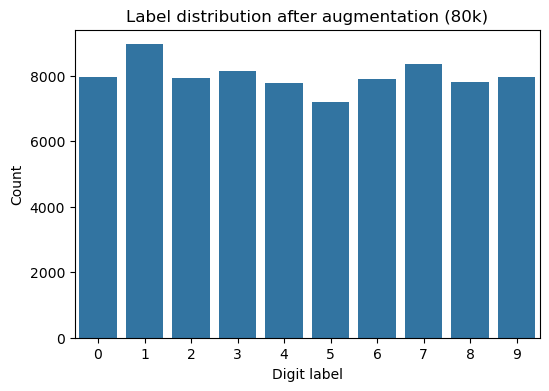

In [14]:
# ==========================================
# Cell 8. Build 80k gray dataset (orig + deskew + font)
# ==========================================
X_gray_80k_u8 = np.concatenate(
    [X_gray_all_u8, X_deskew_u8, X_font_u8],
    axis=0,
)
y_digit_80k = np.concatenate(
    [y_digit_all, y_deskew, y_font],
    axis=0,
)

print("[INFO] X_gray_80k_u8:", X_gray_80k_u8.shape, X_gray_80k_u8.dtype)
print("[INFO] y_digit_80k  :", y_digit_80k.shape)

assert X_gray_80k_u8.shape[0] == TARGET_TOTAL_SAMPLES == 80_000
assert y_digit_80k.shape[0] == TARGET_TOTAL_SAMPLES == 80_000

# EDA: label distribution after augmentation
print("\n[EDA] Label distribution after gray-level augmentation (80k)")
label_counts_80k = pd.Series(y_digit_80k).value_counts().sort_index()
print(label_counts_80k)

plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts_80k.index, y=label_counts_80k.values)
plt.xlabel("Digit label")
plt.ylabel("Count")
plt.title("Label distribution after augmentation (80k)")
plt.show()

[color] processed 10000/80000
[color] processed 20000/80000
[color] processed 30000/80000
[color] processed 40000/80000
[color] processed 50000/80000
[color] processed 60000/80000
[color] processed 70000/80000
[color] processed 80000/80000
[INFO] X_color_80k_u8: (80000, 28, 28, 3) uint8
[INFO] y_fg_80k      : (80000,)
[INFO] y_bg_80k      : (80000,)

[EDA] Foreground color distribution:
    color  count
0     Red  11452
1  Orange  11381
2  Yellow  11500
3   Green  11422
4    Blue  11396
5  Indigo  11517
6  Violet  11332

[EDA] Background color distribution:
    color  count
0     Red  11412
1  Orange  11466
2  Yellow  11276
3   Green  11376
4    Blue  11489
5  Indigo  11499
6  Violet  11482


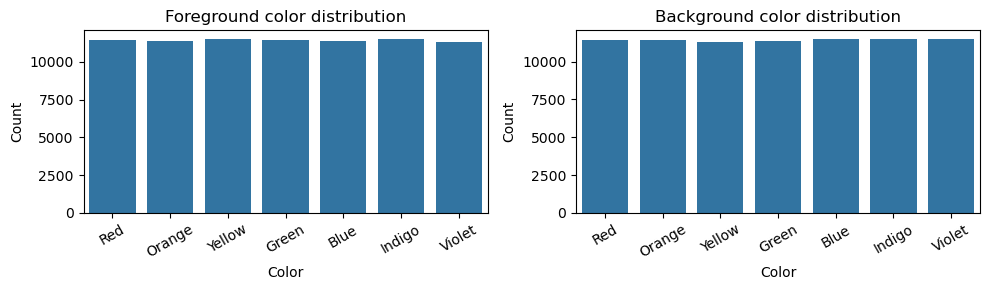

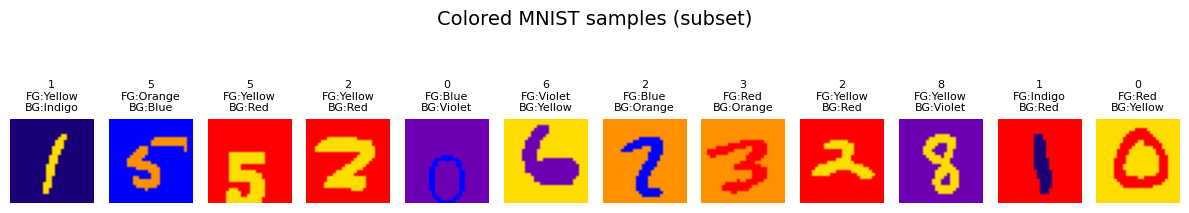

In [15]:
# ==========================================
# Cell 9. Colored MNIST generation
# ==========================================
# Define 7 color palette: ROYGBIV
COLOR_NAMES = ["Red", "Orange", "Yellow", "Green", "Blue", "Indigo", "Violet"]

COLOR_PALETTE = np.array([
    [255,   0,   0],  # Red
    [255, 144,   0],  # Orange
    [255, 220,   0],  # Yellow
    [  0, 255,   0],  # Green
    [  0,   0, 255],  # Blue
    [ 25,   0, 120],  # Indigo
    [110,   0, 180],  # Violet
], dtype=np.uint8)


def sample_fg_bg_colors(rng):
    """
    Sample distinct foreground and background color indices.
    """
    fg = rng.integers(0, len(COLOR_PALETTE))
    bg = rng.integers(0, len(COLOR_PALETTE))
    while bg == fg:
        bg = rng.integers(0, len(COLOR_PALETTE))
    return fg, bg


def colorize_gray_image(img_u8, fg_idx, bg_idx, threshold=30):
    """
    Convert a gray-scale MNIST image into colored image using ROYGBIV palette.
    
    Parameters
    ----------
    img_u8 : np.ndarray, shape (28, 28), uint8
    fg_idx : int
    bg_idx : int
    threshold : int
        Pixel intensity threshold to distinguish foreground from background.
    
    Returns
    -------
    color_img : np.ndarray, shape (28, 28, 3), uint8
    """
    fg_color = COLOR_PALETTE[fg_idx]
    bg_color = COLOR_PALETTE[bg_idx]
    
    h, w = img_u8.shape
    color_img = np.zeros((h, w, 3), dtype=np.uint8)
    color_img[:, :] = bg_color

    mask = img_u8 > threshold
    color_img[mask] = fg_color

    return color_img


def build_colored_mnist(X_gray_u8, rng, threshold=30):
    """
    Build Colored MNIST dataset from gray images.
    
    Parameters
    ----------
    X_gray_u8 : np.ndarray, shape (N, 28, 28), uint8
    rng : np.random.Generator
    threshold : int
    
    Returns
    -------
    X_color_u8 : np.ndarray, shape (N, 28, 28, 3), uint8
    y_fg : np.ndarray, shape (N,), int64
    y_bg : np.ndarray, shape (N,), int64
    """
    N, H, W = X_gray_u8.shape
    X_color_u8 = np.empty((N, H, W, 3), dtype=np.uint8)
    y_fg = np.empty(N, dtype=np.int64)
    y_bg = np.empty(N, dtype=np.int64)
    
    for i in range(N):
        fg_idx, bg_idx = sample_fg_bg_colors(rng)
        X_color_u8[i] = colorize_gray_image(X_gray_u8[i], fg_idx, bg_idx, threshold=threshold)
        y_fg[i] = fg_idx
        y_bg[i] = bg_idx

        if (i + 1) % 10000 == 0:
            print(f"[color] processed {i + 1}/{N}")

    return X_color_u8, y_fg, y_bg


rng_color = np.random.default_rng(RANDOM_SEED + 2)
X_color_80k_u8, y_fg_80k, y_bg_80k = build_colored_mnist(X_gray_80k_u8, rng_color)

print("[INFO] X_color_80k_u8:", X_color_80k_u8.shape, X_color_80k_u8.dtype)
print("[INFO] y_fg_80k      :", y_fg_80k.shape)
print("[INFO] y_bg_80k      :", y_bg_80k.shape)


# EDA: color label distributions
fg_counts = pd.Series(y_fg_80k).value_counts().sort_index()
bg_counts = pd.Series(y_bg_80k).value_counts().sort_index()

print("\n[EDA] Foreground color distribution:")
print(pd.DataFrame({"color": COLOR_NAMES, "count": fg_counts.values}))

print("\n[EDA] Background color distribution:")
print(pd.DataFrame({"color": COLOR_NAMES, "count": bg_counts.values}))

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.barplot(x=list(range(len(COLOR_NAMES))), y=fg_counts.values)
plt.xticks(list(range(len(COLOR_NAMES))), COLOR_NAMES, rotation=30)
plt.title("Foreground color distribution")
plt.xlabel("Color")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.barplot(x=list(range(len(COLOR_NAMES))), y=bg_counts.values)
plt.xticks(list(range(len(COLOR_NAMES))), COLOR_NAMES, rotation=30)
plt.title("Background color distribution")
plt.xlabel("Color")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


# Visualize some colored samples
def show_colored_sample_grid(title, images_u8, y_digit, y_fg, y_bg, n=12):
    """
    Visualize colored samples with digit, fg color, bg color.
    """
    n = min(n, images_u8.shape[0])
    idxs = np.random.choice(images_u8.shape[0], size=n, replace=False)
    
    plt.figure(figsize=(n * 1.0, 2.8))
    for i, idx in enumerate(idxs):
        img = images_u8[idx].astype(np.float32) / 255.0
        d = int(y_digit[idx])
        fg_name = COLOR_NAMES[int(y_fg[idx])]
        bg_name = COLOR_NAMES[int(y_bg[idx])]
        
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{d}\nFG:{fg_name}\nBG:{bg_name}", fontsize=8)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


show_colored_sample_grid(
    "Colored MNIST samples (subset)",
    X_color_80k_u8,
    y_digit_80k,
    y_fg_80k,
    y_bg_80k,
    n=12,
)



[INFO] Split sizes:
  train: 64000
  val  : 8000
  test : 8000

[INFO] Flattened shapes:
  X_train: (64000, 2352) float32
  X_val  : (8000, 2352) float32
  X_test : (8000, 2352) float32
  y_digit_train: (64000,)
  y_fg_train   : (64000,)
  y_bg_train   : (64000,)

[EDA] Label distribution - train
0    6361
1    7167
2    6343
3    6513
4    6226
5    5770
6    6317
7    6685
8    6254
9    6364
Name: count, dtype: int64

[EDA] Label distribution - val
0    795
1    896
2    793
3    814
4    779
5    721
6    789
7    835
8    782
9    796
Name: count, dtype: int64

[EDA] Label distribution - test
0    795
1    895
2    793
3    814
4    778
5    722
6    790
7    836
8    782
9    795
Name: count, dtype: int64


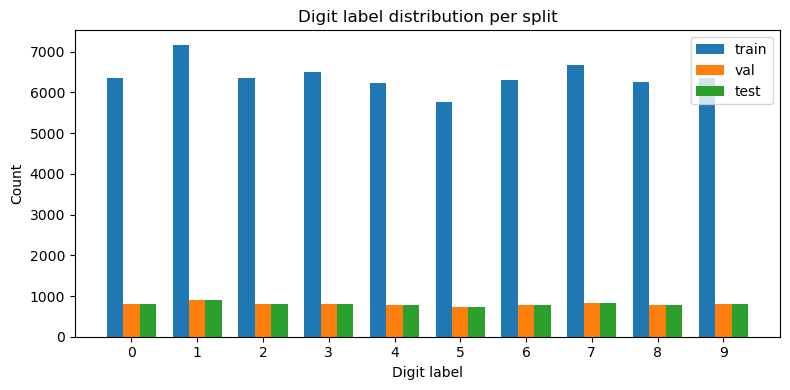

In [16]:
# ==========================================
# Cell 10. 8:1:1 train/val/test split (digit stratified)
# ==========================================
N_total = X_color_80k_u8.shape[0]
indices_all = np.arange(N_total)

# 1) train (80%) vs temp (20%)
train_idx, temp_idx = train_test_split(
    indices_all,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_digit_80k,
)

# 2) temp -> val/test (10%/10%)
y_temp = y_digit_80k[temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=y_temp,
)

print("\n[INFO] Split sizes:")
print("  train:", len(train_idx))
print("  val  :", len(val_idx))
print("  test :", len(test_idx))


def split_arrays(indices, X_color_u8, y_digit, y_fg, y_bg):
    """
    Slice dataset by indices and flatten images to (N, 2352).
    """
    X = X_color_u8[indices]             # (N, 28, 28, 3)
    X_flat = X.reshape(X.shape[0], -1)  # (N, 2352)
    yd = y_digit[indices]
    yfg = y_fg[indices]
    ybg = y_bg[indices]
    return X_flat.astype(np.float32), yd, yfg, ybg


X_train, y_digit_train, y_fg_train, y_bg_train = split_arrays(
    train_idx, X_color_80k_u8, y_digit_80k, y_fg_80k, y_bg_80k
)
X_val, y_digit_val, y_fg_val, y_bg_val = split_arrays(
    val_idx, X_color_80k_u8, y_digit_80k, y_fg_80k, y_bg_80k
)
X_test, y_digit_test, y_fg_test, y_bg_test = split_arrays(
    test_idx, X_color_80k_u8, y_digit_80k, y_fg_80k, y_bg_80k
)

print("\n[INFO] Flattened shapes:")
print("  X_train:", X_train.shape, X_train.dtype)
print("  X_val  :", X_val.shape, X_val.dtype)
print("  X_test :", X_test.shape, X_test.dtype)
print("  y_digit_train:", y_digit_train.shape)
print("  y_fg_train   :", y_fg_train.shape)
print("  y_bg_train   :", y_bg_train.shape)

# EDA: check digit label distribution per split
def print_split_label_distribution(name, y):
    counts = pd.Series(y).value_counts().sort_index()
    print(f"\n[EDA] Label distribution - {name}")
    print(counts)
    return counts

train_counts = print_split_label_distribution("train", y_digit_train)
val_counts = print_split_label_distribution("val", y_digit_val)
test_counts = print_split_label_distribution("test", y_digit_test)

# Simple bar plot to compare distributions (train/val/test)
df_dist = pd.DataFrame({
    "digit": train_counts.index,
    "train": train_counts.values,
    "val":   val_counts.values,
    "test":  test_counts.values,
})

plt.figure(figsize=(8, 4))
width = 0.25
x = np.arange(len(df_dist["digit"]))

plt.bar(x - width, df_dist["train"], width=width, label="train")
plt.bar(x,         df_dist["val"],   width=width, label="val")
plt.bar(x + width, df_dist["test"],  width=width, label="test")

plt.xticks(x, df_dist["digit"])
plt.xlabel("Digit label")
plt.ylabel("Count")
plt.title("Digit label distribution per split")
plt.legend()
plt.tight_layout()
plt.show()



In [17]:
# ==========================================
# Cell 11. Save processed splits (npz)
# ==========================================
np.savez_compressed(
    SAVE_PATH,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    y_digit_train=y_digit_train,
    y_digit_val=y_digit_val,
    y_digit_test=y_digit_test,
    y_fg_train=y_fg_train,
    y_fg_val=y_fg_val,
    y_fg_test=y_fg_test,
    y_bg_train=y_bg_train,
    y_bg_val=y_bg_val,
    y_bg_test=y_bg_test,
)

print("\n[INFO] Saved processed Colored MNIST splits to:")
print("   ", SAVE_PATH)


[INFO] Saved processed Colored MNIST splits to:
    /Users/jaehun_jung/colored-mnist-classification/notebooks/data/processed/colored_mnist/colored_mnist_80k_splits_8_1_1.npz
